## 1. Importing required Libraries


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
import shutil

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from pathlib import Path
import glob

## 2. Mounting google drive so that the dataset can be brought in for training

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Unzipping the dataset to a folder

In [5]:
!mkdir data-resized
!unzip "/content/drive/MyDrive/dataset-resized.zip" -d "data-resized"

Archive:  /content/drive/MyDrive/dataset-resized.zip
   creating: data-resized/dataset-resized/
  inflating: data-resized/dataset-resized/.DS_Store  
   creating: data-resized/__MACOSX/
   creating: data-resized/__MACOSX/dataset-resized/
  inflating: data-resized/__MACOSX/dataset-resized/._.DS_Store  
   creating: data-resized/dataset-resized/cardboard/
  inflating: data-resized/dataset-resized/cardboard/cardboard1.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard10.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard100.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard101.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard102.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard103.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard104.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard105.jpg  
  inflating: data-resized/dataset-resized/cardboard/cardboard106.jpg  
  inflat

## 4. A number of functions:
> ##### a. train_val - to break the dataset into train and validation sets


>##### b. file_name -  gets file names for a particular type of trash, given indices


> ##### c. move_files - moves group of source files to another folder





In [6]:
def file_name(waste_type,indices):
    file_names = []
    for i in indices:
      file_names.append(waste_type+str(i)+".jpg") 
    return(file_names)    

def move_files(start_file,folder):
    for file in start_file:
        shutil.move(file,folder)

def train_val(folder,seed1):    
    length = len(os.listdir(folder))
    full_set = list(range(1,length+1))

    # for Training data
    random.seed(seed1)
    training_set = random.sample(list(range(1,length+1)),int(.75*length))

    # Validation data
    validation_set = list(set(full_set)-set(training_set))

    return(training_set,validation_set)


## 5. Breaking the data into training and validation sets

In [7]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

for subset in subsets:
    for i in waste_types:
        folder = os.path.join('data',subset,i)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
for i in waste_types:
    folder = os.path.join('data-resized/dataset-resized',i)
    train_ind, valid_ind = train_val(folder,1)
    
    # Training set
    train_names = file_name(i,train_ind)
    train_source_files = [os.path.join(folder,name) for name in train_names]
    train_dest = "data/train/"+i
    move_files(train_source_files,train_dest)
    
    # Validation set
    valid_names = file_name(i,valid_ind)
    valid_source_files = [os.path.join(folder,name) for name in valid_names]
    valid_dest = "data/valid/"+i
    move_files(valid_source_files,valid_dest)

In [8]:
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


## 6. Looking at the subtypes of trash
 *(Here **'trash'** is for any other unspecified category)*

In [10]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


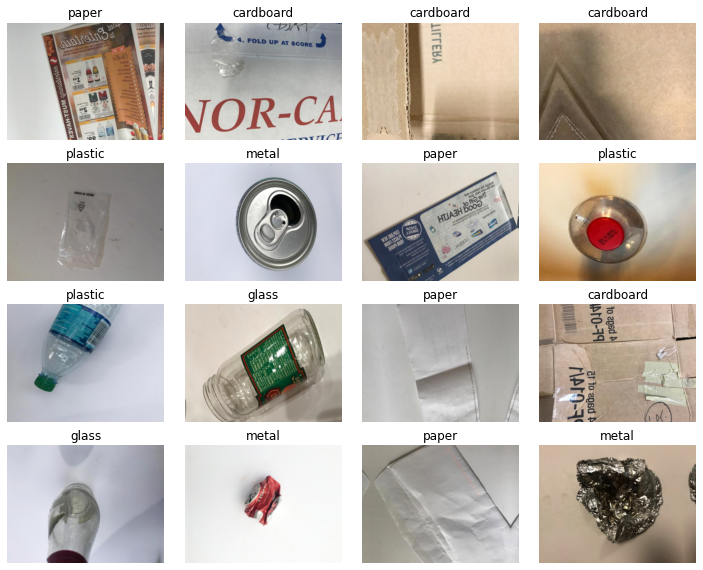

In [11]:
data.show_batch(rows=4,figsize=(10,8))

## 7. Creating model using Resnet18

In [12]:
learn = create_cnn(data,models.resnet18,metrics=[error_rate, accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## 8. Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


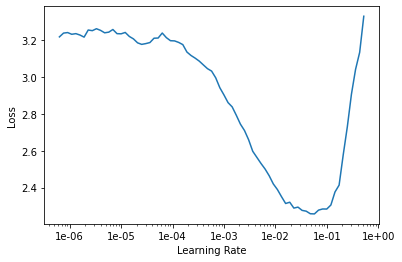

In [14]:
start_lr=1e-7
end_lr=1e1
learn.lr_find(start_lr, end_lr)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(20,max_lr=5.5e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.545959,0.668469,0.245669,0.754331,01:02
1,1.003352,0.520893,0.188976,0.811024,01:00
2,0.805929,0.506882,0.177953,0.822047,00:59
3,0.653841,0.544291,0.176378,0.823622,01:00
4,0.606336,0.664258,0.187402,0.812598,01:00
5,0.591853,0.690877,0.196850,0.803150,01:00
6,0.545477,0.566325,0.174803,0.825197,01:00
7,0.451782,0.376297,0.110236,0.889764,01:00
8,0.413888,0.499729,0.163780,0.836220,00:59
9,0.402966,0.448263,0.144882,0.855118,01:00


## 9. Testing the model

In [16]:
from IPython.display import Image, display

model = learn.model
model = model.cuda()
import glob

/content/drive/MyDrive/0-Test/test1.jpg
Prediction: paper
Throw in the Yellow Dustbin!


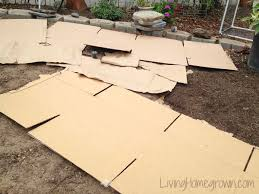



/content/drive/MyDrive/0-Test/test5.jpg
Prediction: paper
Throw in the Yellow Dustbin!


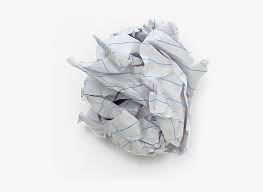



/content/drive/MyDrive/0-Test/test6.jpg
Prediction: plastic
Throw in the Blue Dustbin!


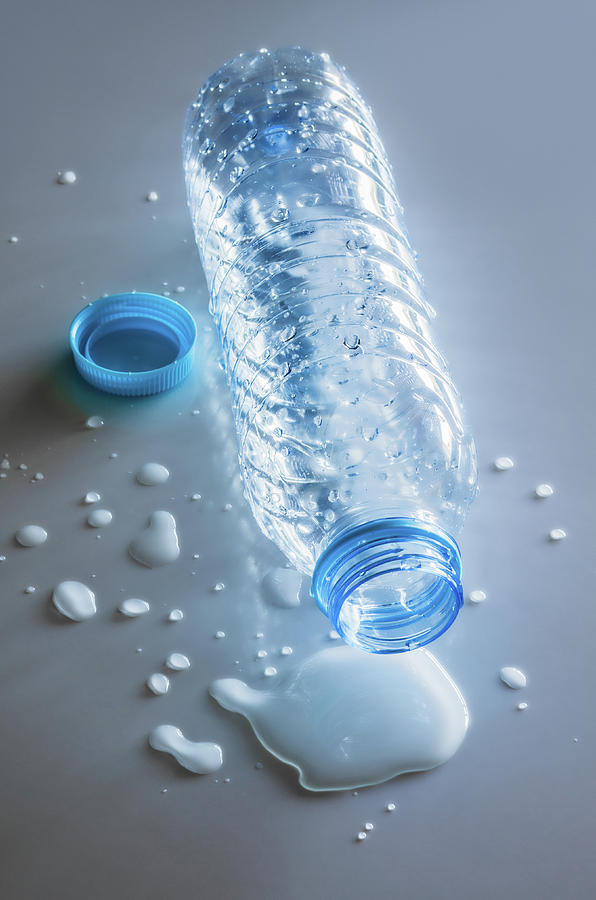



/content/drive/MyDrive/0-Test/test3.jpg
Prediction: metal
Throw in the Blue Dustbin!


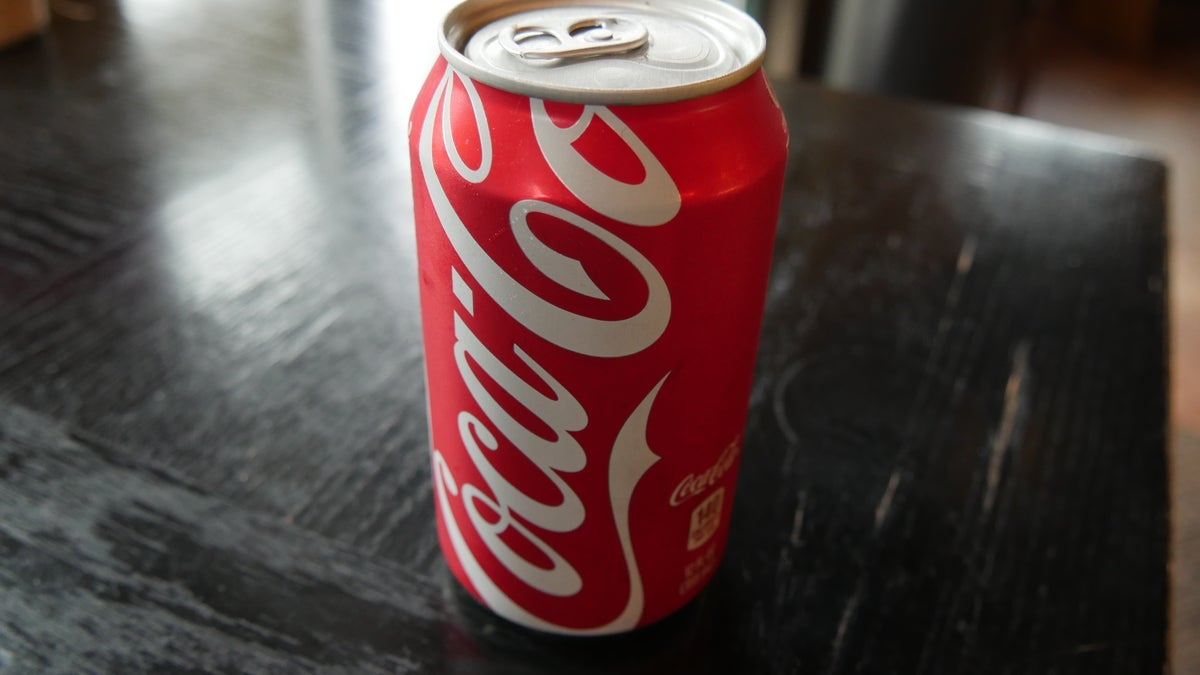



/content/drive/MyDrive/0-Test/test2.jpg
Prediction: glass
Throw in the Yellow Dustbin!


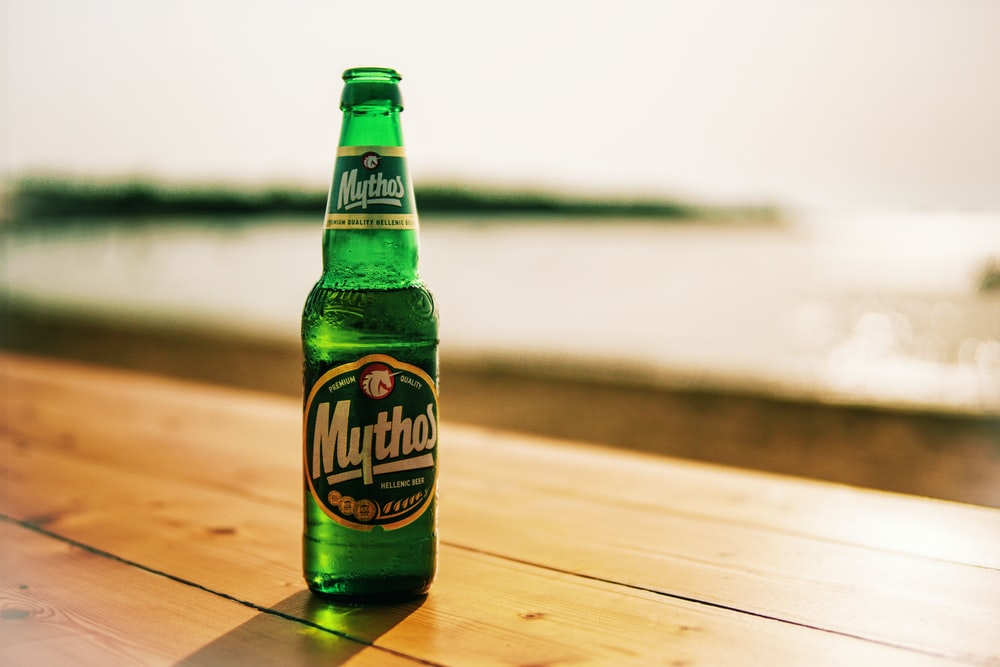

In [17]:
for imageName in glob.glob('/content/drive/MyDrive/0-Test/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    print('Prediction: '+ str(prediction[0]))
    prediction=str(prediction[0])
    if (prediction=='paper' or prediction=='glass' or prediction=='cardboard'):
      print("Throw in the Yellow Dustbin!")
    elif (prediction=='plastic' or prediction=='metal'):
      print("Throw in the Blue Dustbin!")
    else:
      print("Throw in the Green Dustbin!")

    display(Image(filename=imageName, width=300, height=200))
    print("\n")


## Let's try a live image!

In [18]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


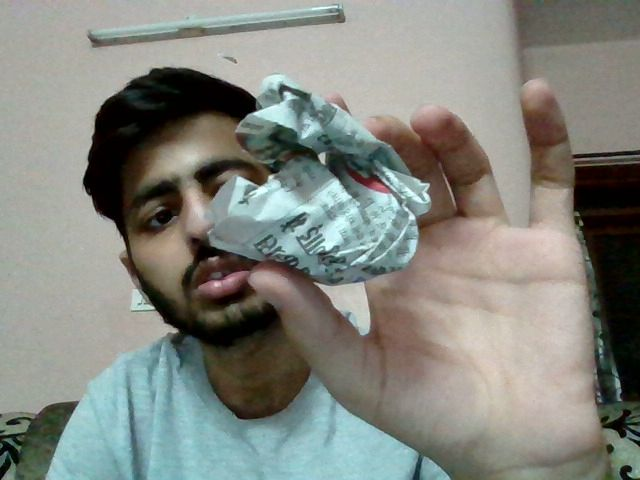

In [23]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

/content/photo.jpg
Prediction: paper
Throw in the Yellow Dustbin!


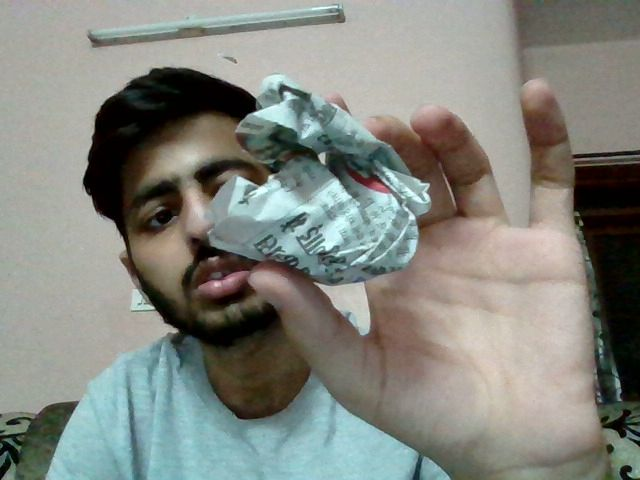

In [24]:
for imageName in glob.glob('/content/photo.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print('Prediction: '+ str(prediction[0]))
    prediction=str(prediction[0])

    if (prediction=='paper' or prediction=='glass' or prediction=='cardboard'):
      print("Throw in the Yellow Dustbin!")
    elif (prediction=='plastic' or prediction=='metal'):
      print("Throw in the Blue Dustbin!")
    else:
      print("Throw in the Green Dustbin!")
      
    display(Image(filename=imageName))
    print("\n")